# Most Read This Week on Goodreads

Course: Text Mining – Models and Algorithms <br>
Problem Set: 3 <br>
Submission Date: Jan 29, 2022 <br>
Authors: Susanu, Cristina; Virgüez, Andrés Felipe; Gannavarapu, Manohar; Schindler, Mathias <br>
Institution: Barcelona School of Economics, Data Science for Decision Making Program, Class of '22


# Introduction

The goal of this notebook is show the code used to scrape data from Goodreads. According to Wikipedia:
    
   *Goodreads is an American social cataloging website and a subsidiary of Amazon that allows individuals to search its database of books, annotations, quotes, and reviews. Users can sign up and register books to generate library catalogs and reading lists. They can also create their own groups of book suggestions, surveys, polls, blogs, and discussions. The website's offices are located in San Francisco*

Goodreads has a section in which shows the top 100 most read books in the last week by genre. Our goal is to get data for 29 genres ($\approx 2,900$ books) that includes:
* Author
* Book name
* Average rating
* Number of ratings
* Year of publication
* Description of the book's summary

An exemplative page from Goodreads that we scrape is presented in the screenshot below.

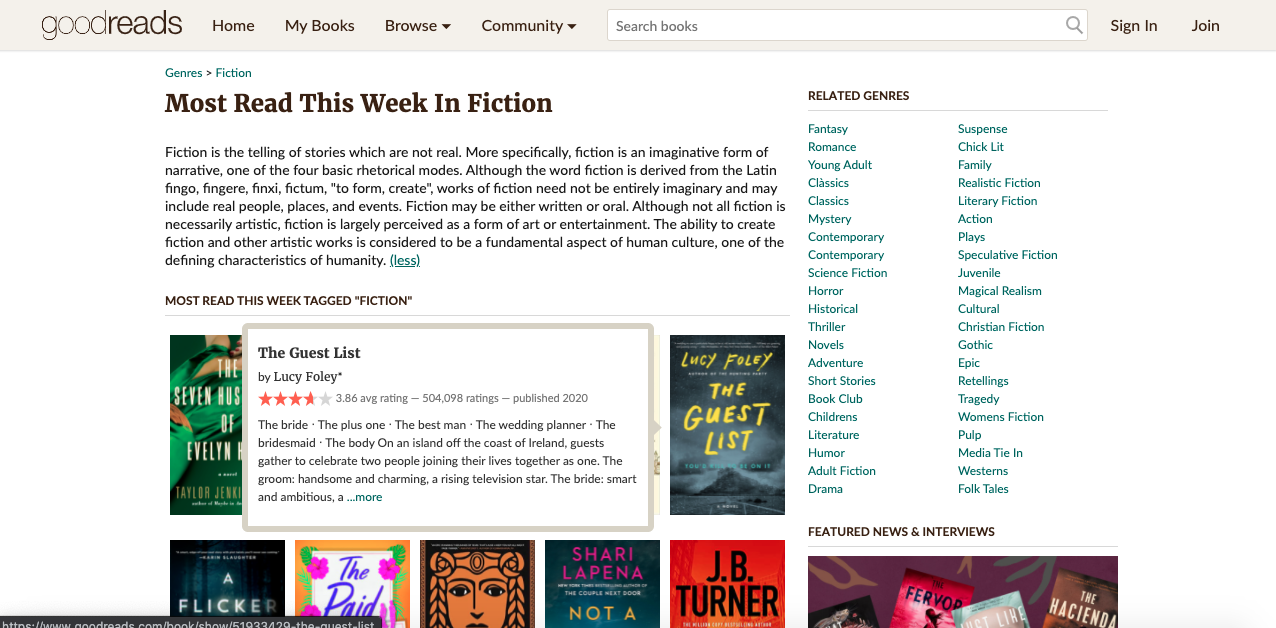

## Scraping

NB: Might be necessary to install `lxml` package

In [28]:
# Importing the libraries
import numpy as np
import pandas as pd

import re
import time
import requests
from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
# Global seaborn options
sns.set(rc={'figure.figsize':(18, 5)}, font_scale=1.25)
sns.set_style("whitegrid")

### Step 1: Get the List of Genres

In [30]:
# Function

def get_all_genres():
    '''
    Function that retrieves all genres available on the goodreads' website
    '''
    url = "https://www.goodreads.com/genres/most_read/"
    genres = []
    page = requests.get(url)
    content = BeautifulSoup(page.text, "lxml")
    for item in content.find_all("a", class_="genreList__genreLink"):
        genres += item
    return list(dict.fromkeys(genres))

In [31]:
# Get the list
print(get_all_genres())
genres = get_all_genres()[:29] # Only fist 29 (the last one is a link to other kind of page)

['Art', 'Biography', 'Business', "Children's", 'Christian', 'Classics', 'Comics', 'Cookbooks', 'Ebooks', 'Fantasy', 'Fiction', 'Graphic Novels', 'Historical Fiction', 'History', 'Horror', 'Memoir', 'Music', 'Mystery', 'Nonfiction', 'Poetry', 'Psychology', 'Romance', 'Science', 'Science Fiction', 'Self Help', 'Sports', 'Thriller', 'Travel', 'Young Adult', 'More Genres']


### Step 2: Get Book Details from Each Specific Genre

In [32]:
# Function

def get_book_details(genre):
    '''
    Function that retrieves all the details of the most read books in the current week
    '''
    # Request the webpage 
    url = "https://www.goodreads.com/genres/most_read/" + genre
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    
    top_class = soup.find_all("div", class_="leftAlignedImage bookBox")
    
    
    try:
        # Use of regex to extract the text fields we are interested in    
        book_url = [re.findall(r'href\=\"([\/a-zA-Z0-9\-]+)', str(i))[0] for i in top_class]    
        book_title = [re.findall(r'alt\=\"(.+)\" class', str(i))[0] for i in top_class]
        book_author = [re.findall(r'\/author\/show\/\d+\.([\_\d\w]+)\"\>', str(i).replace("\\", ""))[0] for i in top_class]
        book_rate = [re.findall(r'(\d\.\d{2}) avg rating', str(i).replace("\\", ""))[0] for i in top_class]
        book_ratings = [re.findall(r'avg rating &mdash; ([\d\,]+) ratings', str(i).replace("\\", ""))[0] for i in top_class]
        book_publisyear = [re.findall(r'&mdash; published (\d{4})n', str(i).replace("\\", ""))[0] for i in top_class]
        book_abstract = [re.findall(r'<span id="freeText\d+" style="display:none">(.+)\.?</span>n', str(i).replace("\\", "")) for i in top_class]

    except Exception:
        print('error')
    
    # Create the data frame
    df = pd.DataFrame(list(zip(book_url, book_title, book_author, book_rate, book_ratings, book_publisyear, book_abstract)),
               columns =["Url", "Title", "Author", "Rate", "Ratings", "Year", "Abstract"])
    
    df['Genre'] = genre # add the genre to the dataframe
    df['Abstract'] = df['Abstract'].astype(str).replace("\[|\]", "", regex = True).replace("", np.nan)
    
    return df

In [33]:
# Testing the function 
print(genres[4])
test_df = get_book_details(genres[4])
print(test_df.shape)
test_df.head()

Christian
(100, 8)


,Url,Title,Author,Rate,Ratings,Year,Abstract,Genre
0,/book/show/56922594-the-stranger-in-the-lifeboat,The Stranger in the Lifeboat,Mitch_Albom,4.19,"18,417",2021,'What would happen if we called on God for hel...,Christian
1,/book/show/56552947-no-cure-for-being-human,No Cure for Being Human: And Other Truths I Ne...,Kate_Bowler,4.23,"7,811",2021,"""n The bestselling author of Everything Happe...",Christian
2,/book/show/55867761-god-bless-this-mess,God Bless This Mess: Learning to Live and Love...,Hannah_Brown,3.85,"5,204",2021,"""&quot;My life was a complete mess, and God bl...",Christian
3,/book/show/57099601-once-upon-a-wardrobe,Once Upon a Wardrobe,Patti_Callahan,4.46,"5,418",2021,"'From Patti Callahan, the bestselling author o...",Christian
4,/book/show/57468098-a-stranger-s-game,A Stranger's Game,Colleen_Coble,4.24,600,2022,'A gripping new stand-alone novel from USA TOD...,Christian


### Step 3: Looping over All the Genres

In [14]:
# This loop extracts the data for all of the 29 genres and creates a single csv file
for i, genre in enumerate(genres):
    if i == 1:
        get_book_details(genre).to_csv('files/goodreads_scraped.csv', index=False)
    else:
        get_book_details(genre).to_csv('files/goodreads_scraped.csv', index=False, mode='a', header=False)

### Bonus: Function to Indicate the Genre to Scrape 

In [15]:
# We had the idea of 

def bonus_genre():
    """ This function ask for a Genre and create a file with the data for that genre """
    
    # Choose a genre
    genres = get_all_genres()
    for i in genres:
        print(i+ " /", end = " ")
    
    df_selected_genre = pd.DataFrame

    while True:
        try:
            selected = input("Please type a genre from the list below: ")
            if selected not in genres:
                raise Exception("sorry!")
        except Exception:
            print("Try again!")
            continue

        if selected == "All":
            if selected in genres:
                for genre in genres:
                    data.append(get_book_details(genre))
                    df_selected_genre = pd.concat(data)
                break
        else:
            get_book_details(selected).to_csv('files/goodreads_' + selected.replace(" ", "") + '.csv', index=False)
            
            break

In [16]:
bonus_genre()

Art / Biography / Business / Children's / Christian / Classics / Comics / Cookbooks / Ebooks / Fantasy / Fiction / Graphic Novels / Historical Fiction / History / Horror / Memoir / Music / Mystery / Nonfiction / Poetry / Psychology / Romance / Science / Science Fiction / Self Help / Sports / Thriller / Travel / Young Adult / More Genres / Please type a genre from the list below: Christian


## Checking and Exploring the Data

In [17]:
df = pd.read_csv('files/goodreads_scraped.csv')
df.head()

,Url,Title,Author,Rate,Ratings,Year,Abstract,Genre
0,/book/show/35133922-educated,Educated,Tara_Westover,4.46,"1,096,027",2018,"""A newer edition of ISBN 9780399590504 can be ...",Biography
1,/book/show/38746485-becoming,Becoming,Michelle_Obama,4.50,"797,347",2018,'In a life filled with meaning and accomplishm...,Biography
2,/book/show/50743767-between-two-kingdoms,Between Two Kingdoms: A Memoir of a Life Inter...,Suleika_Jaouad,4.43,"31,559",2021,"'A searing, deeply moving memoir of illness an...",Biography
3,/book/show/57094309-the-boys,The Boys : A Memoir of Hollywood and Family,Ron_Howard,4.34,"5,347",2021,"'Happy Days, The Andy Griffith Show, Gentle Be...",Biography
4,/book/show/41721428-can-t-hurt-me,Can't Hurt Me: Master Your Mind and Defy the Odds,David_Goggins,4.36,"108,919",2018,"""For David Goggins, childhood was a nightmare ...",Biography


In [18]:
# Check missing data
df.isnull().sum()

Url           0
Title         0
Author        0
Rate          0
Ratings       0
Year          0
Abstract    109
Genre         0
dtype: int64

In [19]:
# 109 books don't have the data of Abstract :(
df[df['Abstract'].isnull()].head(20)

,Url,Title,Author,Rate,Ratings,Year,Abstract,Genre
51,/book/show/59649697-i-am-mine,I Am Mine,Eddie_Vedder,4.10,922,2021,NaN,Biography
113,/book/show/58505300-the-high-5-habit,The High 5 Habit: Take Control of Your Life wi...,Mel_Robbins,4.40,"2,838",2021,NaN,Business
170,/book/show/33517721-the-culture-code,The Culture Code: The Secrets of Highly Succes...,Daniel_Coyle,4.28,"20,271",2017,NaN,Business
407,/book/show/48729531-spy-family-3,"SPY×FAMILY 3 (Spy x Family, #3)",Tatsuya_Endo,4.54,"6,266",2020,NaN,Comics
408,/book/show/49252613-spy-family-4,"SPY×FAMILY 4 (Spy x Family, #4)",Tatsuya_Endo,4.55,"4,961",2020,NaN,Comics
410,/book/show/56304131-34-shingeki-no-kyojin-34,進撃の巨人 34 [Shingeki no Kyojin 34] (Attack on Ti...,Hajime_Isayama,4.46,"5,000",2021,NaN,Comics
413,/book/show/51065933-30-shingeki-no-kyojin-30,進撃の巨人 30 [Shingeki no Kyojin 30] (Attack on Ti...,Hajime_Isayama,4.70,"6,425",2019,NaN,Comics
420,/book/show/56173529-demon-slayer,鬼滅の刃 外伝 [Demon Slayer: Kimetsu no Yaiba Gaiden],Ryoji_Hirano,4.54,639,2020,NaN,Comics
421,/book/show/52671507-2-kieta-hatsukoi-2,"消えた初恋 2 [Kieta Hatsukoi 2] (My Love Mix-Up!, #2)",Wataru_Hinekure,4.42,473,2020,NaN,Comics
422,/book/show/54702017-13,"呪術廻戦 13 (Jujutsu Kaisen, #13)",Gege_Akutami,4.64,"3,356",2020,NaN,Comics


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2545 entries, 0 to 2544
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Url       2545 non-null   object 
 1   Title     2545 non-null   object 
 2   Author    2545 non-null   object 
 3   Rate      2545 non-null   float64
 4   Ratings   2545 non-null   object 
 5   Year      2545 non-null   int64  
 6   Abstract  2436 non-null   object 
 7   Genre     2545 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 159.2+ KB


In [21]:
df['Ratings'] = df['Ratings'].replace('\,', '', regex=True).astype(int)

### Exploring the Data

In [22]:
# Top genres  (most rated)
top_genres = df.groupby('Genre')['Ratings'].sum().to_frame().sort_values('Ratings', ascending=False).reset_index()
top_genres

,Genre,Ratings
0,Classics,71263915
1,Nonfiction,16029677
2,Fiction,10246725
3,Thriller,8314140
4,Romance,7959633
5,Historical Fiction,6648524
6,Mystery,6239532
7,Memoir,5501900
8,Fantasy,4168279
9,Self Help,3547553


<AxesSubplot:xlabel='Rate', ylabel='Density'>

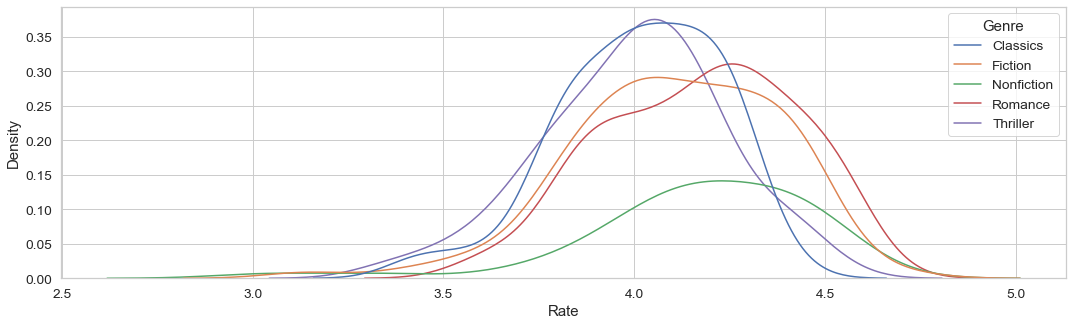

In [23]:
# Distribution plot of top genres
sns.kdeplot(x = 'Rate', hue = 'Genre' , data = df[df['Genre'].isin(list(top_genres.iloc[:5,0]))])

<AxesSubplot:xlabel='Rate', ylabel='Density'>

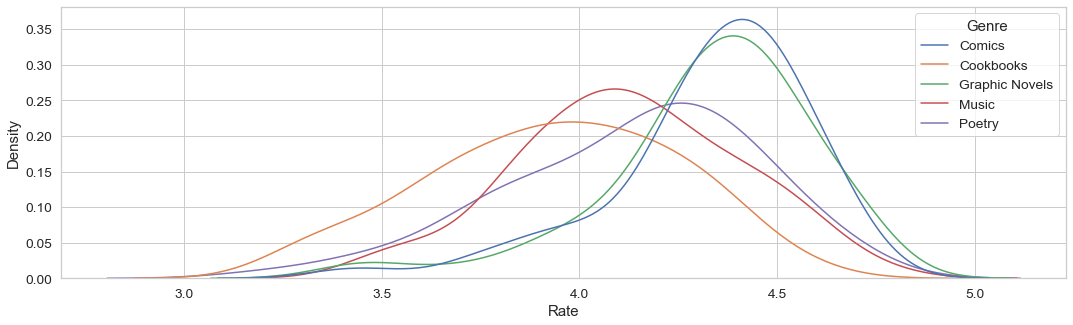

In [24]:
# Distribution plot of the genres with less ratings
sns.kdeplot(x = 'Rate', hue = 'Genre' , data = df[df['Genre'].isin(list(top_genres.iloc[-5:,0]))])

In [25]:
df['Abstract'].str.count(' ').add(1)

0       281.0
1       243.0
2       425.0
3       276.0
4       148.0
        ...  
2540    113.0
2541    145.0
2542    179.0
2543    177.0
2544    155.0
Name: Abstract, Length: 2545, dtype: float64

<AxesSubplot:xlabel='text_n_words', ylabel='Density'>

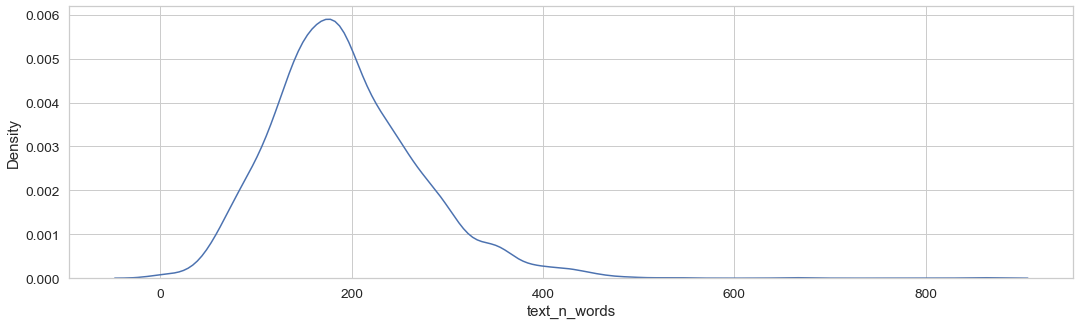

In [26]:
# More important, get some idea of what is in the text data

# Distribution of the number of words
df['text_n_words'] = df['Abstract'].str.count(' ').add(1)
sns.kdeplot(x = 'text_n_words', data = df)

<AxesSubplot:xlabel='text_n_words', ylabel='Density'>

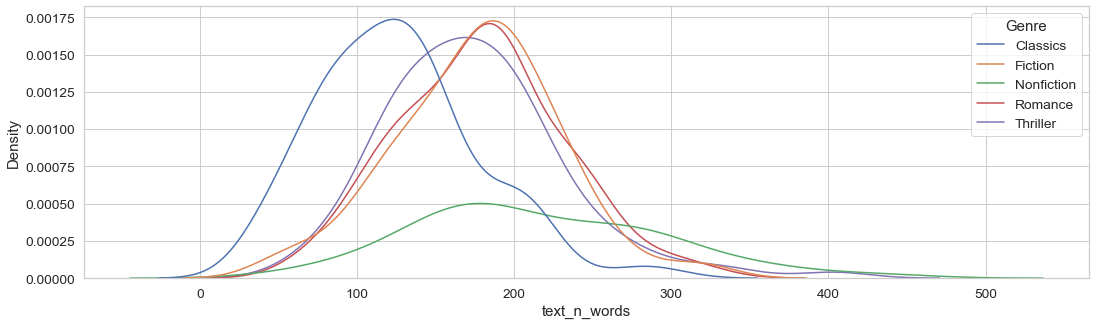

In [27]:
# For some genres
sns.kdeplot(x = 'text_n_words', hue = 'Genre' , data = df[df['Genre'].isin(list(top_genres.iloc[:5,0]))])